# Shark attacks and climate change

## Import libraries and data

In [17]:
# Import libreries
import pandas as pd
import numpy as np
import re
import warnings

# Libraries for maps and plotting 
import geopandas
import geopy 
import matplotlib.pyplot as plt
from geodatasets import get_path
import seaborn as sns


# Import functions 
from functions import *

In [2]:
# Import data

url = 'https://www.sharkattackfile.net/spreadsheets/GSAF5.xls'

shark_attack_raw = pd.read_excel(url)

shark_attack_raw

,Date,Year,Type,Country,State,Location,Activity,Name,Sex,Age,...,Species,Source,pdf,href formula,href,Case Number,Case Number.1,original order,Unnamed: 21,Unnamed: 22
0,15 Mar 2024,2024.0,Unprovoked,AUSTRALIA,Queensland,Bargara Beach,Swimming,Brooklyn Sauer,F,13,...,Tiger shark,"Yahoo News, 3/15/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,04 Mar 2024,2024.0,Unprovoked,USA,Hawaii,"Old Man's, Waikiki",Surfing,Matthew White,M,NaN,...,Tiger shark 8',"Surfer, 3/6/2024F",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,02 Mar-2024,2024.0,Unprovoked,USA,Hawaii,"Rainbows, Oahu",Swimming,NaN,F,11,...,3' to 4' shark,"Hawaii News Now, 3/4/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,25 Feb-2024,2024.0,Unprovoked,AUSTRALIA,Western Australia,"Sandlnd Island, Jurian Bay",NaN,female,F,46,...,Tiger shark,"WA Today, 2/26/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,14 Feb-2024,2024.0,Unprovoked,INDIA,Maharashtra,"Vaitarna River, Palghar District",Fishing,Vicky Suresh Govari,M,32,...,"Bull shark, 7'","Times of India, 2/14/2024",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,http://sharkattackfile.net/spreadsheets/pdf_di...,NaN,NaN,NaN,NaN,NaN,NaN
6965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,http://sharkattackfile.net/spreadsheets/pdf_di...,NaN,NaN,NaN,NaN,NaN,NaN
6966,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,http://sharkattackfile.net/spreadsheets/pdf_di...,NaN,NaN,NaN,NaN,NaN,NaN
6967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,http://sharkattackfile.net/spreadsheets/pdf_di...,NaN,NaN,NaN,NaN,NaN,NaN


## Data processing

In [3]:
# Clean column names
shark_attack_raw = clean_columns_names(shark_attack_raw)

# Clean irrelevant columns
shark_attack_clean = columns_drops(shark_attack_raw, [ 'year', 'type', 'name', 'unnamed:_11', 'time', 'source', 'pdf', 'href_formula', 'href', 'case_number', 'case_number.1',
       'original_order', 'unnamed:_21', 'unnamed:_22'])

In [4]:
# Delete rows with null values
shark_attack_clean = drop_rows_nulls(shark_attack_clean, thresh=2)

In [5]:
# Delete duplicates  
shark_attack_clean.drop_duplicates(inplace=True)

We create  new data set to start editing the values

In [6]:
# Clean dates
shark_attack_values = clean_and_filter_dates(shark_attack_clean, 'date', '1989')

In [7]:
# Categorize injury
shark_attack_values['injury'] = shark_attack_values['injury'].apply(categorize_injury)

In [8]:
# Filter activity
shark_attack_values['activity'] = shark_attack_values['activity'].apply(filter_activity)

In [9]:
# Clean columns with geographical information
shark_attack_values['country'] = shark_attack_values['country'].apply(clean_strings)
shark_attack_values['state'] = shark_attack_values['state'].apply(clean_strings)
shark_attack_values['location'] = shark_attack_values['location'].apply(clean_strings)

In [10]:
# Generate case numbers
shark_attack_values = generate_case_numbers(shark_attack_values)

## Calculate longitude and latitude

We want to use geopy to standardise the location information and obtain the latitude and longitude to represent the attacks on a map. 

In [11]:
# We start by saving the cleaned data in a new csv file.
# We will use this file in the next step.
shark_attack_values.to_csv('shark_attack_clean.csv')

We feed that file to the get_coordinates function to obtain the latitude and longitude coordinates.

We don't want to recalculate this coordinates, as the geopy query takes a long time to process. 
Thus, the followin line is commented:  

In [ ]:
# This funcction will add the coordinates to the dataframe and save it in a new csv.
# pd.read_csv('shark_attack_clean.csv', 'shark_attack_clean_with_coordinates.csv')

## Data analysis

In [34]:
# Load clean data with coordinates
shark_attack_total = pd.read_csv("shark_attack_clean_with_coordinates.csv")

In [27]:
# Let's analyse the distribution of attacks by year. 
# If our hypothesis is correct we will observe an increase during the last decades. 

shark_year_temp = temp_date_df(shark_attack_total, 'date')
shark_year_temp

,year,month,day
0,2024,3,15
1,2024,3,4
2,2024,3,2
3,2024,2,25
4,2024,2,14
...,...,...,...
2958,1990,4,1
2959,1990,3,5
2960,1990,2,17
2961,1990,2,5


In [28]:
shark_year_graph = shark_year_temp.groupby('year').count()
shark_year_graph

,month,day
year,,
1990,37,37
1991,36,36
1992,49,49
1993,39,39
1994,50,50
1995,68,68
1996,54,54
1997,54,54
1998,55,55


In [29]:
#add a column to count the attacks by year
count_by_year = shark_year_temp.groupby('year').size().reset_index(name='attack_count')
temp_date_with_counts = shark_year_graph.merge(count_by_year, on='year', how='left')

/var/folders/yf/ydfr37g56sb7b4mncpm76gk00000gn/T/ipykernel_15776/1047411131.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='attack_count', data= temp_date_with_counts, palette='viridis')


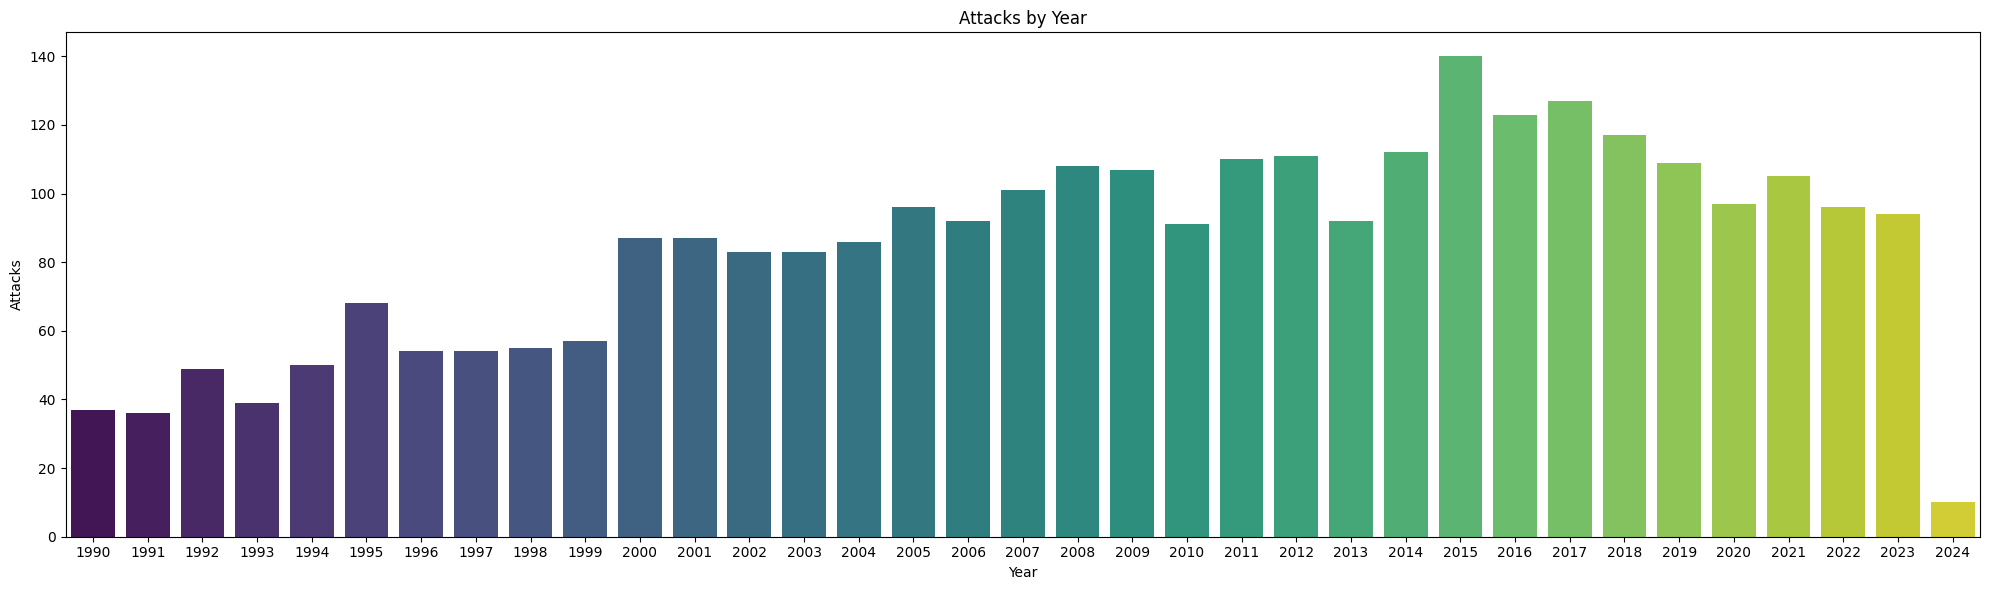

In [20]:
# plot the number of attacks over the years

plt.figure(figsize=(20, 6))
sns.barplot(x='year', y='attack_count', data= temp_date_with_counts, palette='viridis')
plt.xlabel('Year')
plt.ylabel('Attacks')
plt.title('Attacks by Year')
plt.tight_layout()
plt.show()

In [37]:
# 1. Filter mortal attacks (Fatal)
fatal_attacks = shark_attack_total[shark_attack_total['injury'] == 'Fatal']

# 2. Count the amount of fatal attaks per activity
fatal_attacks_by_activity = fatal_attacks.groupby('activity').size().sort_values(ascending=False)

# 3. select the top 5 activities with the most fatal attacks. 
top_5_fatal_attacks = fatal_attacks_by_activity.head(5)


In [38]:
# Count the number of attacks classified as "Fatal" or "No Fatal"
print(shark_attack_total['injury'].value_counts())

injury
No Fatal    2639
Fatal        324
Name: count, dtype: int64


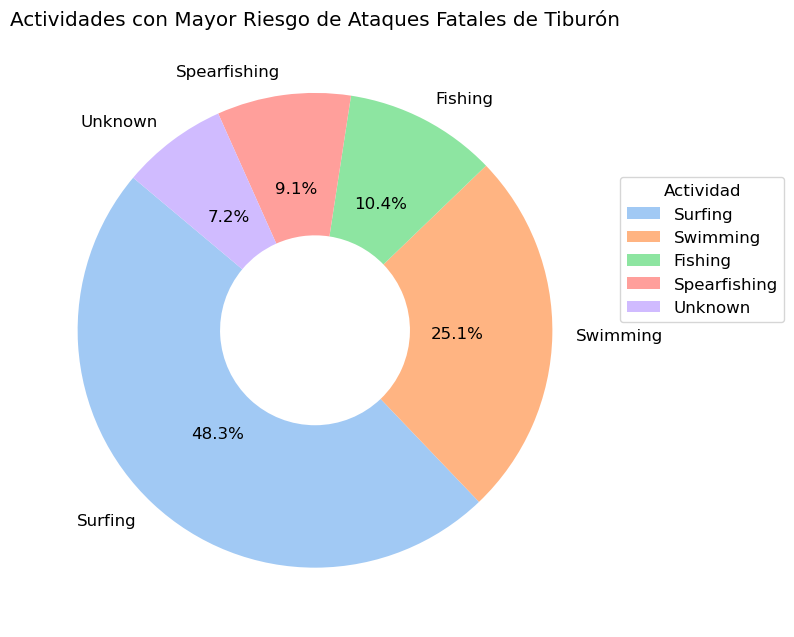

In [131]:
# chart the activities with the most fatal attacks. 

# Use the Seaborn color palette.
# You can choose palettes like "muted", "bright", etc. 
sns.set_palette("muted")  

# Crate the pie chart. 
plt.figure(figsize=(8, 8))
plt.pie(top_5_fatal_attacks, labels=top_5_fatal_attacks.index, autopct='%1.1f%%', startangle=140,
        colors=sns.color_palette("pastel"), wedgeprops=dict(width=0.6))  # Increase the width of the wedges

# Title and legend
plt.title("Actividades con Mayor Riesgo de Ataques Fatales de Tiburón")
plt.legend(title="Actividad", loc="lower left", bbox_to_anchor=(1, 0.5))

# Graphic adjustments
plt.rcParams['font.size'] = 12  # Increase font size
plt.tight_layout()

plt.show()

In [7]:
# plot the attacks on a map

# create geodataframe
gdf = geopandas.GeoDataFrame(
    shark_attack_total, geometry=geopandas.points_from_xy(shark_attack_total.longitude, shark_attack_total.latitude), crs="EPSG:4326"
)
gdf.head()

,Unnamed: 0.1,Unnamed: 0,date,country,state,location,sex,age,species,injury,activity,case_number,latitude,longitude,geometry
0,0,0,2024-03-15,AUSTRALIA,Queensland,Bargara Beach,F,13,Tiger shark,No Fatal,Swimming,ND.2963,-24.815666,152.463247,POINT (152.46325 -24.81567)
1,1,1,2024-03-04,USA,Hawaii,"Old Man's, Waikiki",M,NaN,Tiger shark 8',No Fatal,Surfing,ND.2962,19.593802,-155.428370,POINT (-155.42837 19.5938)
2,2,2,2024-03-02,USA,Hawaii,"Rainbows, Oahu",F,11,3' to 4' shark,No Fatal,Swimming,ND.2961,19.593802,-155.428370,POINT (-155.42837 19.5938)
3,3,3,2024-02-25,AUSTRALIA,Western Australia,"Sandlnd Island, Jurian Bay",F,46,Tiger shark,No Fatal,Unknown,ND.2960,-25.230300,121.018725,POINT (121.01872 -25.2303)
4,4,4,2024-02-14,INDIA,Maharashtra,"Vaitarna River, Palghar District",M,32,"Bull shark, 7'",No Fatal,Fishing,ND.2959,19.743816,73.499828,POINT (73.49983 19.74382)


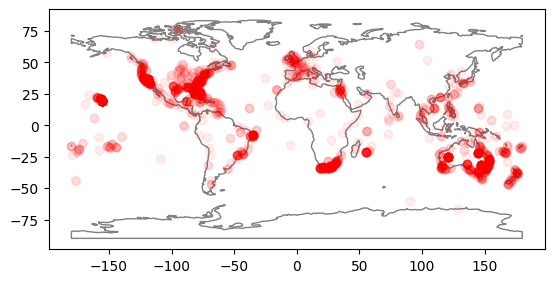

In [8]:
world = geopandas.read_file(get_path("naturalearth.land"))

# We can now plot the ``GeoDataFrame``.
ax = world.clip([-180, -90, 180, 90]).plot(color="white", edgecolor="grey")

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color="red", alpha=0.07)

plt.show()